In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from PIL import Image
from torch.autograd import Variable
import time
import warnings
from matplotlib.ticker import FuncFormatter

warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
manual_seed = int(time.time())
print("Random Seed: ", manual_seed)
random.seed(manual_seed)
torch.manual_seed(manual_seed)

# location of folder
dataroot = "drive/MyDrive/SuperFolderTrainData"
# number of workers
workers = 2
# batch size for training
batch_size = 30
# image size for input
image_size = 128
# number of channel (1 for BW, 3 for RGB)
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 16
# Size of feature maps in generator
ngf = 128
# Size of feature maps in discriminator
ndf = 128
# Number of training epochs
num_epochs = 50
# Learning rate for optimizers
lr = 0.0005
# Style loss weight
sl_loss_weight = 0.03
# Colapse loss weight
cl_loss_weight = 0.03
# Beta values hyperparam for Adam optimizers
beta1 = 0.5
beta2 = 0.99
# Number of GPUs available, currently running on CPU
ngpu = 1
 
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Random Seed:  1623130137
Tesla T4


In [ ]:
# define weights for layer and normalisation
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv')!=-1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm')!=-1:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# setup dataset and data loader
dataset = dset.ImageFolder(root=dataroot, transform=transforms.Compose([transforms.Resize(image_size), 
                                                                        transforms.CenterCrop(image_size),
                                                                        transforms.ToTensor(),
                                                                        transforms.Normalize((0.5,),(0.5,))]))
 
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
 
device = torch.device("cuda:0" if(torch.cuda.is_available() and ngpu>0) else "cpu")

In [ ]:
class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential()
    
    # input z into convolution
    self.main.add_module('conv1', nn.ConvTranspose2d(nz, ngf*8, 8, 2, 0, bias=False))
    self.main.add_module('btch1', nn.BatchNorm2d(ngf*8))
    self.main.add_module('relu1', nn.ReLU(True))

    # state ngf * 8 * 8
    self.main.add_module('conv2', nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False))
    self.main.add_module('btch2', nn.BatchNorm2d(ngf*4))
    self.main.add_module('relu2', nn.ReLU(True))
            
    # state ngf/2 * 16*16
    self.main.add_module('conv3', nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False))
    self.main.add_module('btch3', nn.BatchNorm2d(ngf*2))
    self.main.add_module('relu3', nn.ReLU(True))
            
    # state ngf/4 * 32*32
    self.main.add_module('conv4', nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False))
    self.main.add_module('btch4', nn.BatchNorm2d(ngf))
    self.main.add_module('relu4', nn.ReLU(True))
            
    # state ngf/8 *64*64
    self.main.add_module('conv5', nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False))
    self.main.add_module('output', nn.Tanh())
        
    #state 1 *128*128
        
  def forward(self, input):
    return self.main(input)


# Create the generator
netG = Generator(ngpu).to(device)
 
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
  netG = nn.DataParallel(netG, list(range(ngpu)))
 
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)
 
# Print the model
print(netG)

# Access a particular layer
#print(netG.main.conv1)

# Get tensor of the layer
#print(netG.main.conv1.weight)

Generator(
  (main): Sequential(
    (conv1): ConvTranspose2d(16, 1024, kernel_size=(8, 8), stride=(2, 2), bias=False)
    (btch1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btch2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btch3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (conv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): ReLU(inplace=True)
    (conv5): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential()

    # input is (nc) *128*128
    self.main.add_module('conv1', nn.Conv2d(nc, ndf, 4, 2, 1, bias=False))
    self.main.add_module('relu1', nn.LeakyReLU(0.2, inplace=True))

    # input is ndf/8 *64*64
    self.main.add_module('conv2', nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False))
    self.main.add_module('btch2', nn.BatchNorm2d(ndf*2))
    self.main.add_module('relu2', nn.LeakyReLU(0.2, inplace=True))

    #input is ndf/4 *32*32
    self.main.add_module('conv3', nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False))
    self.main.add_module('btch3', nn.BatchNorm2d(ndf*4))
    self.main.add_module('relu3', nn.LeakyReLU(0.2, inplace=True))

    #input is ndf/2 *16*16
    self.main.add_module('conv4', nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False))
    self.main.add_module('btch4', nn.BatchNorm2d(ndf*8))
    self.main.add_module('relu4', nn.LeakyReLU(0.2, inplace=True))

    #input is ndf *8*8
    self.main.add_module('conv5', nn.Conv2d(ndf*8, 1, 8, 1, 0, bias=False))
    self.main.add_module('output', nn.Sigmoid())

  def forward(self, input):
    return self.main(input), self.main.conv5

# Create the Discriminator
netD = Discriminator(ngpu).to(device)
 
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
  netD = nn.DataParallel(netD, list(range(ngpu)))
 
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)
 
# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (relu1): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btch3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (btch4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): LeakyReLU(negative_slope=0.2, inplace=True)
    (conv5): Conv2d(1024, 1, kernel_size=(8, 8), stride=(1, 1), bias=False)
    (

In [ ]:
def gram_matrix(input):
  a, b, c, d = input.size() # a=batch size(=1) b=number of feature maps (c,d)=dimensions of a f. map (N=c*d)
  features = input.view(a * b, c * d) # resise F_XL into \hat F_XL
  G = torch.mm(features, features.t()) # compute the gram product
  return G.div(a * b * c * d) # we 'normalize' the values of the gram matrix by dividing by the number of element in each feature maps.

def style_loss(style_layer, combination_layer, num_channels = nc):
  assert style_layer.size()==combination_layer.size(), "Input Sizes do not match in StyleLoss"
  a, b, c, d = style_layer.size() # a=batch size(=1) b=number of feature maps (c,d)=dimensions of a f. map (N=c*d)
  styleloss = 0
  
  for i in range(a):
    S = gram_matrix(torch.unsqueeze(style_layer[i], 0)).detach()
    C = gram_matrix(torch.unsqueeze(combination_layer[i],0)).detach()
    styleloss = torch.add(styleloss, torch.sum(torch.square(S-C)/(2*num_channels*c*d)**2)*3e8)
    styleloss = Variable(styleloss, requires_grad=True)

  return styleloss

def colapse_loss(target_feature):
  z_d_gen = torch.flatten(target_feature).reshape(1,-1)
  nom = torch.mm(z_d_gen, z_d_gen.t())
  denom = torch.sqrt(torch.sum(torch.square(z_d_gen), 1, keepdim=True))
  pt = torch.square(torch.transpose((nom / denom), 1, 0))
  #pt = pt - torch.diag(torch.diag(pt))
  pulling_term = torch.sum(pt) / (batch_size * (batch_size - 1)*4e1)
  pulling_term = Variable(pulling_term, requires_grad=True)

  return pulling_term

vgg19 = models.vgg19(pretrained=True).features.to(device).eval()

def get_vgg_layers(input, model=vgg19, num_layer=4):
  i = 0
  Model = copy.deepcopy(model)
  list_layers = nn.ModuleList()
  module = None
  for layer in Model.children():
    if isinstance(layer, nn.Conv2d):
      i +=1
      name = 'conv{}'.format(i)
      list_layers.append(module)
      module = nn.Sequential()
    elif isinstance(layer, nn.ReLU):
      name = 'relu{}'.format(i)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'btnm{}'.format(i)
    else: 
      raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    module.add_module(name, layer)

    if i >= (num_layer+1):
      break

  outconv1 = list_layers[1](input)
  outconv2 = list_layers[2](outconv1)
  outconv3 = list_layers[3](outconv2)
  outconv4 = list_layers[4](outconv3)

  return outconv1, outconv2, outconv3, outconv4

SConv1 shape: torch.Size([1, 64, 128, 128])
SConv2 shape: torch.Size([1, 64, 64, 64])
SConv3 shape: torch.Size([1, 128, 64, 64])
SConv4 shape: torch.Size([1, 128, 32, 32])


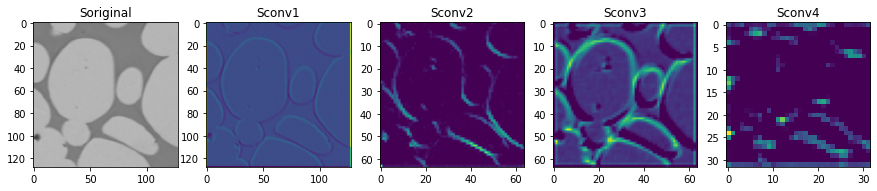

In [ ]:
# Visualise images and feature maps applied over them
loader = transforms.Compose([transforms.Resize(image_size), transforms.CenterCrop(image_size),
                             transforms.ToTensor()])
 
#Style Image
StyleImage = "drive/My Drive/SuperFolderTrainData/TrainData/5399.jpg"
style_image = Image.open(StyleImage)
style_image = loader(style_image)[:3,:,:].unsqueeze(0)

Sconv1, Sconv2, Sconv3, Sconv4 = get_vgg_layers(style_image.to(device, torch.float))
print('SConv1 shape: {}'.format(Sconv1.shape))
print('SConv2 shape: {}'.format(Sconv2.shape))
print('SConv3 shape: {}'.format(Sconv3.shape))
print('SConv4 shape: {}'.format(Sconv4.shape))

visuals = [
    ('Soriginal', style_image),
    ('Sconv1', Sconv1),
    ('Sconv2', Sconv2),
    ('Sconv3', Sconv3),
    ('Sconv4', Sconv4)]

plt.figure(figsize=(15,20))
for i in range(5):
  plt.subplot(1,5,i+1)
  if(i==0):
    plt.imshow(visuals[i][1].squeeze().permute(1,2,0))
  else:
    for j in range(visuals[i][1].squeeze().shape[0]):
      plt.imshow(visuals[i][1].squeeze().cpu().detach().numpy()[j])
  plt.title(visuals[i][0])

In [ ]:
def get_style_colapse_loss(style_batch, gen_batch):
  Sconv1, Sconv2, Sconv3, Sconv4 = get_vgg_layers(style_batch)
  Cconv1, Cconv2, Cconv3, Cconv4 = get_vgg_layers(gen_batch)

  #Sconv1.detach_()
  #Sconv2.detach_()
  #Sconv3.detach_()
  #Sconv4.detach_()
  #Cconv1.detach_()
  #Cconv2.detach_()
  #Cconv3.detach_()
  #Cconv4.detach_()

  # style loss
  s1 = style_loss(Sconv1, Cconv1)
  s2 = style_loss(Sconv2, Cconv2)
  s3 = style_loss(Sconv3, Cconv3)
  s4 = style_loss(Sconv4, Cconv4)
  sl_loss = torch.mean(s1+s2+s3+s4)
  
  Cconv = torch.cat((torch.flatten(Cconv1), torch.flatten(Cconv2), torch.flatten(Cconv3), torch.flatten(Cconv4)), 0)
  # colapse loss
  #c1 = colapse_loss(Cconv1)
  #c2 = colapse_loss(Cconv2)
  #c3 = colapse_loss(Cconv3)
  #c4 = colapse_loss(Cconv4)
  c = colapse_loss(Cconv)
  cl_loss = torch.mean(c) #############(c1+c2+c3+c4)

  return sl_loss, cl_loss

In [ ]:
# Initialize BCELoss function
Dcriterion = nn.BCELoss()
Gcriterion = nn.BCELoss()
 
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(128, nz, 1, 1, device=device)
 
# Establish convention for real and fake labels during training
real_label = 0.
fake_label = 1.
 
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=0.3)
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=0.3)

In [ ]:
# Training loop
img_list = [] #stores prgressive images produced by generator
G_losses = [] #stores progressive losses by generator
D_losses = [] #stores progressive losses by discriminator
G_steps = 1 #train generator in every G_step
D_steps = 3 #train discriminator in every D_step
iter = 0 #track iteration

print('Starting Training')
for epoch in tqdm(range(num_epochs)):
  for i, data in enumerate(dataloader):
    D_realx, D_fakex, D_fakex2 = 0.0, 0.0, 0.0
    errD, errD_real, errD_fake = None, None, None
    fake_x = None
    # Train discriminator
    if i%D_steps==0:
      ############# REAL DATA ###############
      netD.zero_grad() # Reset gradients
      real_x = data[0].to(device) # Load real data
      b_size = real_x.size(0) # Batch size, should be equal to 30 as set earlier
      label = torch.full((b_size,), real_label, dtype=torch.float, device=device) # Set real labels
      output = netD(real_x)[0].view(-1) # Pass real data through discriminator, flatten to keep columns fixed, i.e, b_size

      errD_real = Dcriterion(output, label) # Calculate loss on real data
      errD_real.backward() #Compute gradients

      D_realx = output.mean().item() # Mean output by discriminator over real data

      ############# FAKE DATA ###############
      noise = torch.randn(b_size, nz, 1, 1, device=device) # Generate noise data of b_size
      fake_x = netG(noise) # Create fake images
      label.fill_(fake_label) # Add labels that the data is fake
      output = netD(fake_x.detach())[0].view(-1) # Pass fake data through discriminator, flatten to keep columns fixed, i.e, b_size

      errD_fake = Dcriterion(output, label) # Calculate loss on fake data
      errD_fake.backward() #Compute gradients

      D_fakex = output.mean().item()

      ############# OPTIMIZE DISCRIMINATOR ###############
      errD = errD_real + errD_fake #Adds Gradients as well
      optimizerD.step() # Optimize

    #Train Generator
    netG.zero_grad()
    if i%D_steps != 0:
      real_x = data[0].to(device)
      label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
      noise = torch.randn(b_size, nz, 1, 1, device=device) # Generate noise data of b_size
      fake_x = netG(noise) # Create fake images
      output = netD(fake_x)[0].view(-1) # Pass fake data through discriminator, flatten to keep columns fixed, i.e, b_size

    else:
      label.fill_(real_label)
      output = netD(fake_x)[0].view(-1)

    errG_bce = Gcriterion(output, label)
    errG_bce.backward()
    D_fakex2 = output.mean().item()

    sl_loss, cl_loss = get_style_colapse_loss(real_x, fake_x)
    sl_loss *= sl_loss_weight
    sl_loss.backward()

    cl_loss *= cl_loss_weight
    cl_loss.backward()

    errG = errG_bce + sl_loss + cl_loss
    optimizerG.step()

    #Output for training stats
    if i%60 == 0:
      print('Epoch/Num Epochs: {}/{} | ErrorD: {} | ErrorG: {} | D(realx): {} | D(fakex): {} | D(fakex2): {}'.format(epoch, num_epochs,
                                                                                                                    errD.item(),errG.item(),
                                                                                                                  D_realx,D_fakex,D_fakex2))
      
      print('errD_real: {} | errD_fake: {} | errG_bce: {} | SLoss: {} | CLoss: {}'.format(errD_real.item(),errD_fake.item(),
                                                                                          errG_bce.item(),
                                                                                          sl_loss.item(),
                                                                                          cl_loss.item()))

    # Record Losses
    if i%3==0:
      G_losses.append(errG.item())
      D_losses.append(errD.item())

    if iter%500 == 0:
      with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
      img_list.append(fake)

    iter += 1


  0%|          | 0/50 [00:00<?, ?it/s]

Starting Training
Epoch/Num Epochs: 0/50 | ErrorD: 2.7494802474975586 | ErrorG: 292.31439208984375 | D(realx): 0.3855569362640381 | D(fakex): 0.39015212655067444 | D(fakex2): 1.0
errD_real: 0.935566782951355 | errD_fake: 1.813913345336914 | errG_bce: 100.00000762939453 | SLoss: 123.33570861816406 | CLoss: 68.97867584228516
Epoch/Num Epochs: 0/50 | ErrorD: 15.156197547912598 | ErrorG: 126.64679718017578 | D(realx): 0.009278986603021622 | D(fakex): 0.6340871453285217 | D(fakex2): 0.8238995671272278
errD_real: 0.010864519514143467 | errD_fake: 15.145333290100098 | errG_bce: 76.9310073852539 | SLoss: 24.055641174316406 | CLoss: 25.660146713256836
Epoch/Num Epochs: 0/50 | ErrorD: 26.166696548461914 | ErrorG: 74.0418472290039 | D(realx): 0.8525523543357849 | D(fakex): 0.19946859776973724 | D(fakex2): 0.9913572072982788
errD_real: 15.119651794433594 | errD_fake: 11.04704475402832 | errG_bce: 34.74824523925781 | SLoss: 12.194746971130371 | CLoss: 27.098852157592773


  2%|▏         | 1/50 [01:18<1:04:11, 78.59s/it]

Epoch/Num Epochs: 1/50 | ErrorD: 21.858257293701172 | ErrorG: 53.52268981933594 | D(realx): 0.5161659717559814 | D(fakex): 0.10397785156965256 | D(fakex2): 0.992286205291748
errD_real: 12.64178466796875 | errD_fake: 9.216473579406738 | errG_bce: 29.12396240234375 | SLoss: 4.724429130554199 | CLoss: 19.674299240112305
Epoch/Num Epochs: 1/50 | ErrorD: 13.221895217895508 | ErrorG: 200.01564025878906 | D(realx): 0.9363819360733032 | D(fakex): 1.0 | D(fakex2): 1.0
errD_real: 13.221895217895508 | errD_fake: 0.0 | errG_bce: 100.00000762939453 | SLoss: 52.36666488647461 | CLoss: 47.64897155761719
Epoch/Num Epochs: 1/50 | ErrorD: 29.545827865600586 | ErrorG: 87.06965637207031 | D(realx): 0.978484034538269 | D(fakex): 0.20791395008563995 | D(fakex2): 0.9999837279319763
errD_real: 26.112403869628906 | errD_fake: 3.4334235191345215 | errG_bce: 47.81370544433594 | SLoss: 10.327102661132812 | CLoss: 28.92884635925293


  4%|▍         | 2/50 [02:38<1:03:08, 78.92s/it]

Epoch/Num Epochs: 2/50 | ErrorD: 35.01933288574219 | ErrorG: 92.56027221679688 | D(realx): 0.9989192485809326 | D(fakex): 0.1209828108549118 | D(fakex2): 0.9967530369758606
errD_real: 27.968311309814453 | errD_fake: 7.051021575927734 | errG_bce: 37.30651092529297 | SLoss: 17.871768951416016 | CLoss: 37.381988525390625
Epoch/Num Epochs: 2/50 | ErrorD: 11.758211135864258 | ErrorG: 32.94839096069336 | D(realx): 0.8183702230453491 | D(fakex): 0.09593700617551804 | D(fakex2): 0.9675706028938293
errD_real: 5.308426380157471 | errD_fake: 6.449784755706787 | errG_bce: 6.867356300354004 | SLoss: 3.244450330734253 | CLoss: 22.836584091186523
Epoch/Num Epochs: 2/50 | ErrorD: 13.183842658996582 | ErrorG: 45.33290100097656 | D(realx): 0.9540446996688843 | D(fakex): 0.15806496143341064 | D(fakex2): 0.9997925758361816
errD_real: 9.506457328796387 | errD_fake: 3.677385091781616 | errG_bce: 16.667512893676758 | SLoss: 4.228119373321533 | CLoss: 24.437267303466797


  6%|▌         | 3/50 [03:58<1:02:13, 79.44s/it]

Epoch/Num Epochs: 3/50 | ErrorD: 9.321680068969727 | ErrorG: 42.90302276611328 | D(realx): 0.8967621326446533 | D(fakex): 0.05027395486831665 | D(fakex2): 0.9995269775390625
errD_real: 5.115041255950928 | errD_fake: 4.206639289855957 | errG_bce: 11.178009986877441 | SLoss: 6.164626598358154 | CLoss: 25.560388565063477
Epoch/Num Epochs: 3/50 | ErrorD: 7.908599853515625 | ErrorG: 32.83469772338867 | D(realx): 0.9203287959098816 | D(fakex): 0.23236297070980072 | D(fakex2): 0.9780416488647461
errD_real: 5.2503485679626465 | errD_fake: 2.6582510471343994 | errG_bce: 5.330501556396484 | SLoss: 3.63232421875 | CLoss: 23.871871948242188
Epoch/Num Epochs: 3/50 | ErrorD: 15.115118980407715 | ErrorG: 31.898073196411133 | D(realx): 0.773725152015686 | D(fakex): 0.01903734914958477 | D(fakex2): 0.9944023489952087
errD_real: 7.885075092315674 | errD_fake: 7.230043888092041 | errG_bce: 7.86759614944458 | SLoss: 2.9212701320648193 | CLoss: 21.109207153320312


  8%|▊         | 4/50 [05:19<1:01:09, 79.77s/it]

Epoch/Num Epochs: 4/50 | ErrorD: 6.706291198730469 | ErrorG: 32.2403564453125 | D(realx): 0.7337930202484131 | D(fakex): 0.09522385895252228 | D(fakex2): 0.9181107878684998
errD_real: 3.2175722122192383 | errD_fake: 3.4887187480926514 | errG_bce: 6.164734840393066 | SLoss: 3.389286994934082 | CLoss: 22.68633460998535
Epoch/Num Epochs: 4/50 | ErrorD: 7.860770225524902 | ErrorG: 78.24114227294922 | D(realx): 0.6178454160690308 | D(fakex): 0.04101845622062683 | D(fakex2): 0.9999971985816956
errD_real: 3.106569528579712 | errD_fake: 4.7542009353637695 | errG_bce: 39.71364212036133 | SLoss: 9.690523147583008 | CLoss: 28.836977005004883
Epoch/Num Epochs: 4/50 | ErrorD: 11.02248764038086 | ErrorG: 69.46469116210938 | D(realx): 0.9553717970848083 | D(fakex): 0.12758684158325195 | D(fakex2): 0.9988698959350586
errD_real: 8.029715538024902 | errD_fake: 2.992772340774536 | errG_bce: 9.752753257751465 | SLoss: 21.868757247924805 | CLoss: 37.84318161010742


 10%|█         | 5/50 [06:39<59:59, 79.99s/it]  

Epoch/Num Epochs: 5/50 | ErrorD: 9.355619430541992 | ErrorG: 35.93315887451172 | D(realx): 0.8894038200378418 | D(fakex): 0.09253352135419846 | D(fakex2): 0.9051088094711304
errD_real: 4.610153675079346 | errD_fake: 4.745465278625488 | errG_bce: 6.172271251678467 | SLoss: 4.4965128898620605 | CLoss: 25.264373779296875
Epoch/Num Epochs: 5/50 | ErrorD: 4.540852069854736 | ErrorG: 91.55327606201172 | D(realx): 0.37107017636299133 | D(fakex): 0.3879950940608978 | D(fakex2): 0.999030590057373
errD_real: 1.624773383140564 | errD_fake: 2.916078805923462 | errG_bce: 50.51423645019531 | SLoss: 11.033441543579102 | CLoss: 30.005598068237305
Epoch/Num Epochs: 5/50 | ErrorD: 9.067054748535156 | ErrorG: 95.99021911621094 | D(realx): 0.8914993405342102 | D(fakex): 0.07055269926786423 | D(fakex2): 0.9973300099372864
errD_real: 4.595709800720215 | errD_fake: 4.4713454246521 | errG_bce: 8.906874656677246 | SLoss: 40.887481689453125 | CLoss: 46.195865631103516


 12%|█▏        | 6/50 [08:00<58:49, 80.21s/it]

Epoch/Num Epochs: 6/50 | ErrorD: 7.385775566101074 | ErrorG: 104.64181518554688 | D(realx): 0.905768096446991 | D(fakex): 0.17111441493034363 | D(fakex2): 0.9993897080421448
errD_real: 4.73061466217041 | errD_fake: 2.655160665512085 | errG_bce: 8.901716232299805 | SLoss: 49.969783782958984 | CLoss: 45.770320892333984
Epoch/Num Epochs: 6/50 | ErrorD: 10.811469078063965 | ErrorG: 105.98052978515625 | D(realx): 0.7638513445854187 | D(fakex): 0.04570523276925087 | D(fakex2): 0.9957874417304993
errD_real: 6.052166938781738 | errD_fake: 4.759302139282227 | errG_bce: 6.969815254211426 | SLoss: 52.231910705566406 | CLoss: 46.778804779052734
Epoch/Num Epochs: 6/50 | ErrorD: 6.504314422607422 | ErrorG: 128.15252685546875 | D(realx): 0.6372926235198975 | D(fakex): 0.034583866596221924 | D(fakex2): 0.9977098703384399
errD_real: 1.7131367921829224 | errD_fake: 4.791177749633789 | errG_bce: 16.298498153686523 | SLoss: 60.25312805175781 | CLoss: 51.60089111328125


 14%|█▍        | 7/50 [09:21<57:32, 80.28s/it]

Epoch/Num Epochs: 7/50 | ErrorD: 9.109573364257812 | ErrorG: 74.89482879638672 | D(realx): 0.7898829579353333 | D(fakex): 0.07853876799345016 | D(fakex2): 0.9992518424987793
errD_real: 3.9718589782714844 | errD_fake: 5.137714862823486 | errG_bce: 10.143583297729492 | SLoss: 28.07240867614746 | CLoss: 36.678836822509766
Epoch/Num Epochs: 7/50 | ErrorD: 8.499204635620117 | ErrorG: 99.73715209960938 | D(realx): 0.9603474140167236 | D(fakex): 0.2876752018928528 | D(fakex2): 0.9896408319473267
errD_real: 5.976868152618408 | errD_fake: 2.522336483001709 | errG_bce: 5.654735565185547 | SLoss: 47.25339889526367 | CLoss: 46.82902145385742
Epoch/Num Epochs: 7/50 | ErrorD: 2.645852565765381 | ErrorG: 28.786678314208984 | D(realx): 0.6215544939041138 | D(fakex): 0.49947115778923035 | D(fakex2): 0.8592272996902466
errD_real: 1.7507176399230957 | errD_fake: 0.8951348662376404 | errG_bce: 2.8573358058929443 | SLoss: 5.34200382232666 | CLoss: 20.587339401245117


 16%|█▌        | 8/50 [10:41<56:14, 80.34s/it]

Epoch/Num Epochs: 8/50 | ErrorD: 9.223858833312988 | ErrorG: 127.32527160644531 | D(realx): 0.6223891377449036 | D(fakex): 0.05537038668990135 | D(fakex2): 0.9996733665466309
errD_real: 5.205258846282959 | errD_fake: 4.018599987030029 | errG_bce: 13.38058853149414 | SLoss: 66.01739501953125 | CLoss: 47.92729568481445
Epoch/Num Epochs: 8/50 | ErrorD: 5.357223033905029 | ErrorG: 92.1805419921875 | D(realx): 0.14931762218475342 | D(fakex): 0.06699599325656891 | D(fakex2): 0.999639093875885
errD_real: 0.244423970580101 | errD_fake: 5.112799167633057 | errG_bce: 23.673765182495117 | SLoss: 34.66073226928711 | CLoss: 33.84605026245117
Epoch/Num Epochs: 8/50 | ErrorD: 4.4311676025390625 | ErrorG: 169.24453735351562 | D(realx): 0.04969141259789467 | D(fakex): 0.10574635118246078 | D(fakex2): 0.9999984502792358
errD_real: 0.12259414792060852 | errD_fake: 4.308573246002197 | errG_bce: 48.3577995300293 | SLoss: 69.42105102539062 | CLoss: 51.46569061279297


 18%|█▊        | 9/50 [12:02<54:55, 80.38s/it]

Epoch/Num Epochs: 9/50 | ErrorD: 7.648542404174805 | ErrorG: 151.33062744140625 | D(realx): 0.15205329656600952 | D(fakex): 0.1407952755689621 | D(fakex2): 0.9996439218521118
errD_real: 3.5449416637420654 | errD_fake: 4.103600978851318 | errG_bce: 35.028724670410156 | SLoss: 68.50980377197266 | CLoss: 47.79209518432617
Epoch/Num Epochs: 9/50 | ErrorD: 8.110333442687988 | ErrorG: 86.57103729248047 | D(realx): 0.11471939831972122 | D(fakex): 0.0374709852039814 | D(fakex2): 0.9986931085586548
errD_real: 0.28680625557899475 | errD_fake: 7.8235273361206055 | errG_bce: 42.95115280151367 | SLoss: 15.70737075805664 | CLoss: 27.912513732910156
Epoch/Num Epochs: 9/50 | ErrorD: 4.7859368324279785 | ErrorG: 207.01351928710938 | D(realx): 0.8050963878631592 | D(fakex): 0.9889562129974365 | D(fakex2): 0.9448664784431458
errD_real: 4.773863315582275 | errD_fake: 0.012073660269379616 | errG_bce: 8.404467582702637 | SLoss: 145.2186737060547 | CLoss: 53.390384674072266


 20%|██        | 10/50 [13:21<53:28, 80.20s/it]

Epoch/Num Epochs: 10/50 | ErrorD: 2.3222055435180664 | ErrorG: 39.42148208618164 | D(realx): 0.3565956950187683 | D(fakex): 0.47541573643684387 | D(fakex2): 0.9846978783607483
errD_real: 0.971156895160675 | errD_fake: 1.3510485887527466 | errG_bce: 6.012805938720703 | SLoss: 10.687294960021973 | CLoss: 22.72138214111328
Epoch/Num Epochs: 10/50 | ErrorD: 8.865912437438965 | ErrorG: 49.63743591308594 | D(realx): 0.11039840430021286 | D(fakex): 0.000664684281218797 | D(fakex2): 0.999362051486969
errD_real: 0.1895684450864792 | errD_fake: 8.67634391784668 | errG_bce: 9.414715766906738 | SLoss: 13.992907524108887 | CLoss: 26.229814529418945
Epoch/Num Epochs: 10/50 | ErrorD: 6.478329181671143 | ErrorG: 24.102367401123047 | D(realx): 0.9082919359207153 | D(fakex): 0.39647093415260315 | D(fakex2): 0.8320162892341614
errD_real: 4.642406463623047 | errD_fake: 1.8359225988388062 | errG_bce: 2.6439154148101807 | SLoss: 4.363873481750488 | CLoss: 17.09457778930664


 22%|██▏       | 11/50 [14:42<52:09, 80.25s/it]

Epoch/Num Epochs: 11/50 | ErrorD: 5.13776159286499 | ErrorG: 28.624839782714844 | D(realx): 0.6911836266517639 | D(fakex): 0.10172975063323975 | D(fakex2): 0.9971286058425903
errD_real: 2.230085849761963 | errD_fake: 2.9076757431030273 | errG_bce: 6.596558570861816 | SLoss: 5.115396022796631 | CLoss: 16.912885665893555
Epoch/Num Epochs: 11/50 | ErrorD: 5.591341018676758 | ErrorG: 16.27655792236328 | D(realx): 0.9027127027511597 | D(fakex): 0.1867118775844574 | D(fakex2): 0.9507366418838501
errD_real: 3.291749954223633 | errD_fake: 2.299591302871704 | errG_bce: 5.213864326477051 | SLoss: 1.8360037803649902 | CLoss: 9.226690292358398
Epoch/Num Epochs: 11/50 | ErrorD: 5.366633415222168 | ErrorG: 17.15813446044922 | D(realx): 0.7690363526344299 | D(fakex): 0.09608185291290283 | D(fakex2): 0.9847409725189209
errD_real: 2.04154896736145 | errD_fake: 3.325084686279297 | errG_bce: 5.353924751281738 | SLoss: 1.5407007932662964 | CLoss: 10.263507843017578


 24%|██▍       | 12/50 [16:03<50:55, 80.41s/it]

Epoch/Num Epochs: 12/50 | ErrorD: 3.7227001190185547 | ErrorG: 19.838926315307617 | D(realx): 0.20071743428707123 | D(fakex): 0.08111695200204849 | D(fakex2): 0.9995740652084351
errD_real: 0.5041679739952087 | errD_fake: 3.218532085418701 | errG_bce: 9.25547981262207 | SLoss: 2.3978219032287598 | CLoss: 8.185625076293945
Epoch/Num Epochs: 12/50 | ErrorD: 3.8503031730651855 | ErrorG: 15.598119735717773 | D(realx): 0.7058043479919434 | D(fakex): 0.17091304063796997 | D(fakex2): 0.9771474599838257
errD_real: 1.61887526512146 | errD_fake: 2.2314279079437256 | errG_bce: 4.659143447875977 | SLoss: 1.5556877851486206 | CLoss: 9.383288383483887
Epoch/Num Epochs: 12/50 | ErrorD: 6.229880332946777 | ErrorG: 30.36388397216797 | D(realx): 0.3315562605857849 | D(fakex): 0.00653090002015233 | D(fakex2): 0.9999418258666992
errD_real: 0.6664589047431946 | errD_fake: 5.563421249389648 | errG_bce: 11.086606979370117 | SLoss: 3.6548221111297607 | CLoss: 15.622455596923828


 26%|██▌       | 13/50 [17:23<49:34, 80.40s/it]

Epoch/Num Epochs: 13/50 | ErrorD: 6.201274871826172 | ErrorG: 15.513776779174805 | D(realx): 0.7952844500541687 | D(fakex): 0.46341124176979065 | D(fakex2): 0.9620559215545654
errD_real: 5.237509250640869 | errD_fake: 0.9637653827667236 | errG_bce: 4.523362636566162 | SLoss: 2.1940345764160156 | CLoss: 8.796380043029785
Epoch/Num Epochs: 13/50 | ErrorD: 3.687530994415283 | ErrorG: 13.44400405883789 | D(realx): 0.9402193427085876 | D(fakex): 0.8003718256950378 | D(fakex2): 0.8429873585700989
errD_real: 3.4255409240722656 | errD_fake: 0.2619900405406952 | errG_bce: 2.2002081871032715 | SLoss: 1.5566682815551758 | CLoss: 9.687128067016602
Epoch/Num Epochs: 13/50 | ErrorD: 5.835694789886475 | ErrorG: 10.858621597290039 | D(realx): 0.9878291487693787 | D(fakex): 0.9086951613426208 | D(fakex2): 0.6636747121810913
errD_real: 5.737440586090088 | errD_fake: 0.09825443476438522 | errG_bce: 1.4231171607971191 | SLoss: 2.172189235687256 | CLoss: 7.263315200805664


 28%|██▊       | 14/50 [18:43<48:14, 80.39s/it]

Epoch/Num Epochs: 14/50 | ErrorD: 4.823171615600586 | ErrorG: 22.567378997802734 | D(realx): 0.8267360925674438 | D(fakex): 0.2515726089477539 | D(fakex2): 0.9946352243423462
errD_real: 2.767793655395508 | errD_fake: 2.055377960205078 | errG_bce: 5.8841872215271 | SLoss: 3.7639963626861572 | CLoss: 12.919196128845215
Epoch/Num Epochs: 14/50 | ErrorD: 1.9702658653259277 | ErrorG: 19.563798904418945 | D(realx): 0.10153118520975113 | D(fakex): 0.1958029568195343 | D(fakex2): 0.9560835957527161
errD_real: 0.11975683271884918 | errD_fake: 1.8505090475082397 | errG_bce: 4.504720211029053 | SLoss: 2.867264747619629 | CLoss: 12.191813468933105
Epoch/Num Epochs: 14/50 | ErrorD: 2.2561705112457275 | ErrorG: 18.73163604736328 | D(realx): 0.6281362175941467 | D(fakex): 0.4332506060600281 | D(fakex2): 0.8585233688354492
errD_real: 1.3670200109481812 | errD_fake: 0.8891504406929016 | errG_bce: 6.5927228927612305 | SLoss: 2.094111442565918 | CLoss: 10.04480266571045


 30%|███       | 15/50 [20:03<46:46, 80.19s/it]

Epoch/Num Epochs: 15/50 | ErrorD: 3.925116777420044 | ErrorG: 20.904945373535156 | D(realx): 0.9235498309135437 | D(fakex): 0.5607516169548035 | D(fakex2): 0.6387072205543518
errD_real: 3.2952516078948975 | errD_fake: 0.6298651099205017 | errG_bce: 1.283172845840454 | SLoss: 4.275200366973877 | CLoss: 15.34657096862793
Epoch/Num Epochs: 15/50 | ErrorD: 0.969732403755188 | ErrorG: 14.88211441040039 | D(realx): 0.4783952832221985 | D(fakex): 0.7764950394630432 | D(fakex2): 0.8777345418930054
errD_real: 0.7069883346557617 | errD_fake: 0.26274406909942627 | errG_bce: 2.958589792251587 | SLoss: 2.80857515335083 | CLoss: 9.114949226379395
Epoch/Num Epochs: 15/50 | ErrorD: 5.845722675323486 | ErrorG: 15.452922821044922 | D(realx): 0.994065523147583 | D(fakex): 0.972993016242981 | D(fakex2): 0.8632574081420898
errD_real: 5.818157196044922 | errD_fake: 0.027565402910113335 | errG_bce: 2.6494507789611816 | SLoss: 2.1910812854766846 | CLoss: 10.612390518188477


 32%|███▏      | 16/50 [21:22<45:18, 79.96s/it]

Epoch/Num Epochs: 16/50 | ErrorD: 4.662729740142822 | ErrorG: 19.578937530517578 | D(realx): 0.6507644653320312 | D(fakex): 0.06298159062862396 | D(fakex2): 0.99982750415802
errD_real: 1.4158700704574585 | errD_fake: 3.246859550476074 | errG_bce: 9.584200859069824 | SLoss: 1.5826351642608643 | CLoss: 8.412100791931152
Epoch/Num Epochs: 16/50 | ErrorD: 2.73699951171875 | ErrorG: 16.264179229736328 | D(realx): 0.7383963465690613 | D(fakex): 0.468910276889801 | D(fakex2): 0.9492054581642151
errD_real: 1.7724148035049438 | errD_fake: 0.9645847082138062 | errG_bce: 3.534223794937134 | SLoss: 2.058408737182617 | CLoss: 10.671547889709473
Epoch/Num Epochs: 16/50 | ErrorD: 3.0408241748809814 | ErrorG: 33.994606018066406 | D(realx): 0.8474149703979492 | D(fakex): 0.6496224403381348 | D(fakex2): 0.8973921537399292
errD_real: 2.5252468585968018 | errD_fake: 0.5155773162841797 | errG_bce: 2.5348761081695557 | SLoss: 10.50340461730957 | CLoss: 20.956327438354492


 34%|███▍      | 17/50 [22:42<43:52, 79.78s/it]

Epoch/Num Epochs: 17/50 | ErrorD: 3.452177047729492 | ErrorG: 31.257675170898438 | D(realx): 0.8244355320930481 | D(fakex): 0.32392817735671997 | D(fakex2): 0.9935440421104431
errD_real: 2.174877643585205 | errD_fake: 1.277299404144287 | errG_bce: 5.552250862121582 | SLoss: 7.028800010681152 | CLoss: 18.676624298095703
Epoch/Num Epochs: 17/50 | ErrorD: 3.265202522277832 | ErrorG: 25.643749237060547 | D(realx): 0.7490542531013489 | D(fakex): 0.26886045932769775 | D(fakex2): 0.989240825176239
errD_real: 1.791490912437439 | errD_fake: 1.4737117290496826 | errG_bce: 5.596701622009277 | SLoss: 4.072234630584717 | CLoss: 15.974812507629395
Epoch/Num Epochs: 17/50 | ErrorD: 4.1038408279418945 | ErrorG: 21.319473266601562 | D(realx): 0.780097246170044 | D(fakex): 0.23237808048725128 | D(fakex2): 0.9228950142860413
errD_real: 2.428973436355591 | errD_fake: 1.6748676300048828 | errG_bce: 3.179161548614502 | SLoss: 4.408966541290283 | CLoss: 13.731344223022461


 36%|███▌      | 18/50 [24:01<42:26, 79.59s/it]

Epoch/Num Epochs: 18/50 | ErrorD: 3.1602156162261963 | ErrorG: 16.355533599853516 | D(realx): 0.5794495940208435 | D(fakex): 0.2043129801750183 | D(fakex2): 0.9836836457252502
errD_real: 1.339107871055603 | errD_fake: 1.8211077451705933 | errG_bce: 4.797451972961426 | SLoss: 2.6502792835235596 | CLoss: 8.90780258178711
Epoch/Num Epochs: 18/50 | ErrorD: 4.614344120025635 | ErrorG: 18.389883041381836 | D(realx): 0.9598116278648376 | D(fakex): 0.5793675780296326 | D(fakex2): 0.7859002947807312
errD_real: 4.007516860961914 | errD_fake: 0.6068271994590759 | errG_bce: 1.6677327156066895 | SLoss: 3.038438081741333 | CLoss: 13.683712005615234
Epoch/Num Epochs: 18/50 | ErrorD: 3.963563919067383 | ErrorG: 30.145418167114258 | D(realx): 0.8483558893203735 | D(fakex): 0.3263496458530426 | D(fakex2): 0.999721109867096
errD_real: 2.4990973472595215 | errD_fake: 1.4644664525985718 | errG_bce: 9.068373680114746 | SLoss: 5.624781131744385 | CLoss: 15.452262878417969


 38%|███▊      | 19/50 [25:20<41:05, 79.53s/it]

Epoch/Num Epochs: 19/50 | ErrorD: 2.7052595615386963 | ErrorG: 22.720314025878906 | D(realx): 0.14019611477851868 | D(fakex): 0.08972840756177902 | D(fakex2): 0.9990870952606201
errD_real: 0.1572636216878891 | errD_fake: 2.5479960441589355 | errG_bce: 7.676341533660889 | SLoss: 2.495307207107544 | CLoss: 12.548664093017578
Epoch/Num Epochs: 19/50 | ErrorD: 1.4935139417648315 | ErrorG: 17.375932693481445 | D(realx): 0.5001503825187683 | D(fakex): 0.5518386960029602 | D(fakex2): 0.9061928391456604
errD_real: 0.8425465822219849 | errD_fake: 0.6509673595428467 | errG_bce: 2.5420010089874268 | SLoss: 2.025373935699463 | CLoss: 12.808557510375977
Epoch/Num Epochs: 19/50 | ErrorD: 3.6486308574676514 | ErrorG: 18.7387752532959 | D(realx): 0.9180684089660645 | D(fakex): 0.661466121673584 | D(fakex2): 0.8815023899078369
errD_real: 3.2111756801605225 | errD_fake: 0.43745526671409607 | errG_bce: 2.234156847000122 | SLoss: 2.551281690597534 | CLoss: 13.953336715698242


 40%|████      | 20/50 [26:40<39:48, 79.63s/it]

Epoch/Num Epochs: 20/50 | ErrorD: 2.343977212905884 | ErrorG: 13.898172378540039 | D(realx): 0.2820863127708435 | D(fakex): 0.1491362303495407 | D(fakex2): 0.8792118430137634
errD_real: 0.3640132546424866 | errD_fake: 1.979964017868042 | errG_bce: 2.3666694164276123 | SLoss: 1.436315655708313 | CLoss: 10.095187187194824
Epoch/Num Epochs: 20/50 | ErrorD: 3.1386799812316895 | ErrorG: 16.798995971679688 | D(realx): 0.8879124522209167 | D(fakex): 0.5530332922935486 | D(fakex2): 0.932286262512207
errD_real: 2.509978771209717 | errD_fake: 0.6287011504173279 | errG_bce: 2.82023024559021 | SLoss: 2.517707109451294 | CLoss: 11.461058616638184
Epoch/Num Epochs: 20/50 | ErrorD: 2.4626100063323975 | ErrorG: 13.690227508544922 | D(realx): 0.5025472044944763 | D(fakex): 0.23264510929584503 | D(fakex2): 0.8884968757629395
errD_real: 0.8058947920799255 | errD_fake: 1.6567151546478271 | errG_bce: 2.8983402252197266 | SLoss: 1.4993129968643188 | CLoss: 9.292574882507324


 42%|████▏     | 21/50 [28:00<38:28, 79.60s/it]

Epoch/Num Epochs: 21/50 | ErrorD: 2.0228078365325928 | ErrorG: 18.33599090576172 | D(realx): 0.460430771112442 | D(fakex): 0.2760251760482788 | D(fakex2): 0.9754125475883484
errD_real: 0.6851422786712646 | errD_fake: 1.3376655578613281 | errG_bce: 4.03824520111084 | SLoss: 1.6248233318328857 | CLoss: 12.67292308807373
Epoch/Num Epochs: 21/50 | ErrorD: 4.222759246826172 | ErrorG: 22.69867706298828 | D(realx): 0.9196749925613403 | D(fakex): 0.3018416464328766 | D(fakex2): 0.9821326732635498
errD_real: 2.995826005935669 | errD_fake: 1.2269331216812134 | errG_bce: 4.166901588439941 | SLoss: 3.149106502532959 | CLoss: 15.382668495178223
Epoch/Num Epochs: 21/50 | ErrorD: 3.5694546699523926 | ErrorG: 11.083327293395996 | D(realx): 0.9259073138237 | D(fakex): 0.7192076444625854 | D(fakex2): 0.5933558940887451
errD_real: 3.2286362648010254 | errD_fake: 0.34081849455833435 | errG_bce: 0.9564995765686035 | SLoss: 1.6643548011779785 | CLoss: 8.462472915649414


 44%|████▍     | 22/50 [29:19<37:08, 79.60s/it]

Epoch/Num Epochs: 22/50 | ErrorD: 2.0720036029815674 | ErrorG: 16.135456085205078 | D(realx): 0.5527790188789368 | D(fakex): 0.35358133912086487 | D(fakex2): 0.9066400527954102
errD_real: 0.9198035597801208 | errD_fake: 1.1521999835968018 | errG_bce: 2.514435052871704 | SLoss: 2.3242337703704834 | CLoss: 11.29678726196289
Epoch/Num Epochs: 22/50 | ErrorD: 0.974224328994751 | ErrorG: 12.232502937316895 | D(realx): 0.40227770805358887 | D(fakex): 0.6682921648025513 | D(fakex2): 0.6882190704345703
errD_real: 0.5506860613822937 | errD_fake: 0.42353829741477966 | errG_bce: 1.212759256362915 | SLoss: 1.6728408336639404 | CLoss: 9.346902847290039
Epoch/Num Epochs: 22/50 | ErrorD: 1.8612090349197388 | ErrorG: 11.999908447265625 | D(realx): 0.4638703167438507 | D(fakex): 0.3113807737827301 | D(fakex2): 0.8690485954284668
errD_real: 0.6581788063049316 | errD_fake: 1.2030302286148071 | errG_bce: 2.065361261367798 | SLoss: 1.3107494115829468 | CLoss: 8.623798370361328


 46%|████▌     | 23/50 [30:39<35:52, 79.71s/it]

Epoch/Num Epochs: 23/50 | ErrorD: 1.2416497468948364 | ErrorG: 13.94606876373291 | D(realx): 0.6016717553138733 | D(fakex): 0.7662769556045532 | D(fakex2): 0.7671964168548584
errD_real: 0.9710803031921387 | errD_fake: 0.27056947350502014 | errG_bce: 1.536501407623291 | SLoss: 1.4531301259994507 | CLoss: 10.956437110900879
Epoch/Num Epochs: 23/50 | ErrorD: 2.8357245922088623 | ErrorG: 16.73092269897461 | D(realx): 0.9098231196403503 | D(fakex): 0.8064854145050049 | D(fakex2): 0.63932865858078
errD_real: 2.6104040145874023 | errD_fake: 0.22532056272029877 | errG_bce: 1.128009557723999 | SLoss: 2.2464869022369385 | CLoss: 13.356426239013672
Epoch/Num Epochs: 23/50 | ErrorD: 1.8326019048690796 | ErrorG: 15.007072448730469 | D(realx): 0.40410202741622925 | D(fakex): 0.28546738624572754 | D(fakex2): 0.9664930105209351
errD_real: 0.5366817712783813 | errD_fake: 1.2959201335906982 | errG_bce: 3.5449135303497314 | SLoss: 1.2854340076446533 | CLoss: 10.176724433898926


 48%|████▊     | 24/50 [31:59<34:31, 79.69s/it]

Epoch/Num Epochs: 24/50 | ErrorD: 1.652457594871521 | ErrorG: 13.331733703613281 | D(realx): 0.5837230086326599 | D(fakex): 0.5057386159896851 | D(fakex2): 0.7144072651863098
errD_real: 0.9151446223258972 | errD_fake: 0.7373129725456238 | errG_bce: 1.4572169780731201 | SLoss: 2.348071813583374 | CLoss: 9.526445388793945
Epoch/Num Epochs: 24/50 | ErrorD: 1.6829947233200073 | ErrorG: 28.284788131713867 | D(realx): 0.7378315925598145 | D(fakex): 0.8080898523330688 | D(fakex2): 0.7949619889259338
errD_real: 1.4647947549819946 | errD_fake: 0.2181999683380127 | errG_bce: 1.6170240640640259 | SLoss: 7.197085380554199 | CLoss: 19.470678329467773
Epoch/Num Epochs: 24/50 | ErrorD: 2.8458940982818604 | ErrorG: 18.072370529174805 | D(realx): 0.521030604839325 | D(fakex): 0.13579900562763214 | D(fakex2): 0.7922698259353638
errD_real: 0.7967455387115479 | errD_fake: 2.0491485595703125 | errG_bce: 1.6767672300338745 | SLoss: 2.5997254848480225 | CLoss: 13.795878410339355


 50%|█████     | 25/50 [33:18<33:11, 79.66s/it]

Epoch/Num Epochs: 25/50 | ErrorD: 2.338357925415039 | ErrorG: 20.188426971435547 | D(realx): 0.05326589196920395 | D(fakex): 0.11139379441738129 | D(fakex2): 0.9797663688659668
errD_real: 0.055159274488687515 | errD_fake: 2.283198595046997 | errG_bce: 3.952515125274658 | SLoss: 2.068098545074463 | CLoss: 14.167814254760742
Epoch/Num Epochs: 25/50 | ErrorD: 2.046330451965332 | ErrorG: 13.214786529541016 | D(realx): 0.4849684536457062 | D(fakex): 0.26986825466156006 | D(fakex2): 0.8384267687797546
errD_real: 0.6786310076713562 | errD_fake: 1.367699384689331 | errG_bce: 1.9149268865585327 | SLoss: 1.5589045286178589 | CLoss: 9.740955352783203
Epoch/Num Epochs: 25/50 | ErrorD: 1.742051124572754 | ErrorG: 21.006296157836914 | D(realx): 0.4616391062736511 | D(fakex): 0.34300002455711365 | D(fakex2): 0.908049464225769
errD_real: 0.6449865698814392 | errD_fake: 1.0970646142959595 | errG_bce: 2.420410394668579 | SLoss: 3.3422653675079346 | CLoss: 15.243620872497559


 52%|█████▏    | 26/50 [34:38<31:53, 79.73s/it]

Epoch/Num Epochs: 26/50 | ErrorD: 1.632406234741211 | ErrorG: 12.291692733764648 | D(realx): 0.36538034677505493 | D(fakex): 0.3248154819011688 | D(fakex2): 0.8546454906463623
errD_real: 0.47813159227371216 | errD_fake: 1.154274582862854 | errG_bce: 1.9907608032226562 | SLoss: 1.298714280128479 | CLoss: 9.002217292785645
Epoch/Num Epochs: 26/50 | ErrorD: 0.6219048500061035 | ErrorG: 18.91686248779297 | D(realx): 0.2183210253715515 | D(fakex): 0.6967642903327942 | D(fakex2): 0.960990309715271
errD_real: 0.2540552616119385 | errD_fake: 0.36784958839416504 | errG_bce: 3.3808960914611816 | SLoss: 2.2397313117980957 | CLoss: 13.296234130859375
Epoch/Num Epochs: 26/50 | ErrorD: 1.3064261674880981 | ErrorG: 25.83738136291504 | D(realx): 0.23323121666908264 | D(fakex): 0.3612063527107239 | D(fakex2): 0.8863583207130432
errD_real: 0.27308860421180725 | errD_fake: 1.0333375930786133 | errG_bce: 2.217233419418335 | SLoss: 5.9704766273498535 | CLoss: 17.64967155456543


 54%|█████▍    | 27/50 [35:58<30:33, 79.71s/it]

Epoch/Num Epochs: 27/50 | ErrorD: 1.1085731983184814 | ErrorG: 15.021646499633789 | D(realx): 0.5735090970993042 | D(fakex): 0.8202422261238098 | D(fakex2): 0.5199148654937744
errD_real: 0.9079954624176025 | errD_fake: 0.2005777508020401 | errG_bce: 0.7777777910232544 | SLoss: 1.469870924949646 | CLoss: 12.773998260498047
Epoch/Num Epochs: 27/50 | ErrorD: 1.2838410139083862 | ErrorG: 17.517494201660156 | D(realx): 0.4098409414291382 | D(fakex): 0.4803304970264435 | D(fakex2): 0.9337080121040344
errD_real: 0.5390130877494812 | errD_fake: 0.744827926158905 | errG_bce: 2.7548880577087402 | SLoss: 2.188049554824829 | CLoss: 12.574556350708008
Epoch/Num Epochs: 27/50 | ErrorD: 1.7414370775222778 | ErrorG: 12.685371398925781 | D(realx): 0.37242230772972107 | D(fakex): 0.290414959192276 | D(fakex2): 0.8540055751800537
errD_real: 0.4887511730194092 | errD_fake: 1.2526859045028687 | errG_bce: 2.1509649753570557 | SLoss: 1.68201744556427 | CLoss: 8.852389335632324


 56%|█████▌    | 28/50 [37:18<29:14, 79.76s/it]

Epoch/Num Epochs: 28/50 | ErrorD: 1.7623838186264038 | ErrorG: 15.528584480285645 | D(realx): 0.31702086329460144 | D(fakex): 0.2716663181781769 | D(fakex2): 0.9118502736091614
errD_real: 0.40151193737983704 | errD_fake: 1.3608719110488892 | errG_bce: 2.574570655822754 | SLoss: 2.0011911392211914 | CLoss: 10.9528226852417
Epoch/Num Epochs: 28/50 | ErrorD: 2.235377788543701 | ErrorG: 19.073081970214844 | D(realx): 0.5577411651611328 | D(fakex): 0.28001266717910767 | D(fakex2): 0.8743205666542053
errD_real: 0.8861764669418335 | errD_fake: 1.3492013216018677 | errG_bce: 2.084188222885132 | SLoss: 4.165482044219971 | CLoss: 12.823412895202637
Epoch/Num Epochs: 28/50 | ErrorD: 1.8431984186172485 | ErrorG: 23.754981994628906 | D(realx): 0.7389023303985596 | D(fakex): 0.6487354040145874 | D(fakex2): 0.699883222579956
errD_real: 1.4036937952041626 | errD_fake: 0.43950462341308594 | errG_bce: 1.2206025123596191 | SLoss: 5.7905964851379395 | CLoss: 16.743783950805664


 58%|█████▊    | 29/50 [38:37<27:53, 79.69s/it]

Epoch/Num Epochs: 29/50 | ErrorD: 1.6110061407089233 | ErrorG: 12.832951545715332 | D(realx): 0.4881216585636139 | D(fakex): 0.39613935351371765 | D(fakex2): 0.8261198997497559
errD_real: 0.677136242389679 | errD_fake: 0.9338698983192444 | errG_bce: 1.793960452079773 | SLoss: 1.583359956741333 | CLoss: 9.455631256103516
Epoch/Num Epochs: 29/50 | ErrorD: 2.3401622772216797 | ErrorG: 13.319446563720703 | D(realx): 0.8774423599243164 | D(fakex): 0.8373146057128906 | D(fakex2): 0.7943904995918274
errD_real: 2.1591882705688477 | errD_fake: 0.18097394704818726 | errG_bce: 1.7768045663833618 | SLoss: 2.383115768432617 | CLoss: 9.159525871276855
Epoch/Num Epochs: 29/50 | ErrorD: 0.13478198647499084 | ErrorG: 16.411602020263672 | D(realx): 0.040758151561021805 | D(fakex): 0.9159678220748901 | D(fakex2): 0.9237397313117981
errD_real: 0.046282172203063965 | errD_fake: 0.08849981427192688 | errG_bce: 2.784945249557495 | SLoss: 3.472576379776001 | CLoss: 10.154081344604492


 60%|██████    | 30/50 [39:57<26:33, 79.67s/it]

Epoch/Num Epochs: 30/50 | ErrorD: 1.6245397329330444 | ErrorG: 8.651226043701172 | D(realx): 0.7558866143226624 | D(fakex): 0.8920190930366516 | D(fakex2): 0.6699474453926086
errD_real: 1.509002923965454 | errD_fake: 0.11553677171468735 | errG_bce: 1.1990201473236084 | SLoss: 2.2884809970855713 | CLoss: 5.16372537612915
Epoch/Num Epochs: 30/50 | ErrorD: 0.16707250475883484 | ErrorG: 11.45698070526123 | D(realx): 0.07502304762601852 | D(fakex): 0.9164606928825378 | D(fakex2): 0.9403737783432007
errD_real: 0.07893192023038864 | errD_fake: 0.0881405919790268 | errG_bce: 2.9496216773986816 | SLoss: 1.9304614067077637 | CLoss: 6.576897621154785
Epoch/Num Epochs: 30/50 | ErrorD: 0.4412153959274292 | ErrorG: 13.440324783325195 | D(realx): 0.032312773168087006 | D(fakex): 0.6701356768608093 | D(fakex2): 0.9244808554649353
errD_real: 0.03414665162563324 | errD_fake: 0.40706872940063477 | errG_bce: 2.737456798553467 | SLoss: 2.7879531383514404 | CLoss: 7.914915084838867


 62%|██████▏   | 31/50 [41:17<25:15, 79.75s/it]

Epoch/Num Epochs: 31/50 | ErrorD: 0.20953962206840515 | ErrorG: 16.55679702758789 | D(realx): 0.01972765289247036 | D(fakex): 0.8333845138549805 | D(fakex2): 0.9947692155838013
errD_real: 0.01997932605445385 | errD_fake: 0.18956029415130615 | errG_bce: 5.2804436683654785 | SLoss: 2.4135169982910156 | CLoss: 8.862835884094238
Epoch/Num Epochs: 31/50 | ErrorD: 0.32270702719688416 | ErrorG: 19.768043518066406 | D(realx): 0.20318052172660828 | D(fakex): 0.9117414355278015 | D(fakex2): 0.967438280582428
errD_real: 0.22956395149230957 | errD_fake: 0.09314307570457458 | errG_bce: 3.489011764526367 | SLoss: 4.518654823303223 | CLoss: 11.7603759765625
Epoch/Num Epochs: 31/50 | ErrorD: 0.09760621190071106 | ErrorG: 16.144718170166016 | D(realx): 0.013443762436509132 | D(fakex): 0.9196354746818542 | D(fakex2): 0.9448053240776062
errD_real: 0.013554087840020657 | errD_fake: 0.08405212312936783 | errG_bce: 2.912213087081909 | SLoss: 3.2144174575805664 | CLoss: 10.018086433410645


 64%|██████▍   | 32/50 [42:37<23:54, 79.71s/it]

Epoch/Num Epochs: 32/50 | ErrorD: 0.042017314583063126 | ErrorG: 12.777755737304688 | D(realx): 0.006166658829897642 | D(fakex): 0.9648582935333252 | D(fakex2): 0.9799509644508362
errD_real: 0.006199282594025135 | errD_fake: 0.035818032920360565 | errG_bce: 3.9441890716552734 | SLoss: 2.5500082969665527 | CLoss: 6.283558368682861
Epoch/Num Epochs: 32/50 | ErrorD: 0.046613357961177826 | ErrorG: 10.816991806030273 | D(realx): 0.0037383190356194973 | D(fakex): 0.958069384098053 | D(fakex2): 0.967728853225708
errD_real: 0.0037474464625120163 | errD_fake: 0.04286591336131096 | errG_bce: 3.457409620285034 | SLoss: 2.5143847465515137 | CLoss: 4.845198154449463
Epoch/Num Epochs: 32/50 | ErrorD: 0.025605877861380577 | ErrorG: 12.113712310791016 | D(realx): 0.004529440775513649 | D(fakex): 0.9791738390922546 | D(fakex2): 0.9816751480102539
errD_real: 0.004543708637356758 | errD_fake: 0.02106216922402382 | errG_bce: 4.123252868652344 | SLoss: 2.164156913757324 | CLoss: 5.826302528381348


 66%|██████▌   | 33/50 [43:56<22:32, 79.57s/it]

Epoch/Num Epochs: 33/50 | ErrorD: 1.8364841938018799 | ErrorG: 14.275703430175781 | D(realx): 0.0896037220954895 | D(fakex): 0.27426689863204956 | D(fakex2): 0.9824092388153076
errD_real: 0.0948503166437149 | errD_fake: 1.7416338920593262 | errG_bce: 4.099120140075684 | SLoss: 2.2866296768188477 | CLoss: 7.889954090118408
Epoch/Num Epochs: 33/50 | ErrorD: 0.5348476767539978 | ErrorG: 13.7542724609375 | D(realx): 0.1875976026058197 | D(fakex): 0.7262728810310364 | D(fakex2): 0.8787304162979126
errD_real: 0.20911020040512085 | errD_fake: 0.32573747634887695 | errG_bce: 2.1418256759643555 | SLoss: 2.738233804702759 | CLoss: 8.874213218688965
Epoch/Num Epochs: 33/50 | ErrorD: 0.7888982892036438 | ErrorG: 18.879653930664062 | D(realx): 0.3722793459892273 | D(fakex): 0.7366142868995667 | D(fakex2): 0.9429234266281128
errD_real: 0.48102739453315735 | errD_fake: 0.30787089467048645 | errG_bce: 2.9008002281188965 | SLoss: 3.8381080627441406 | CLoss: 12.140746116638184


 68%|██████▊   | 34/50 [45:15<21:12, 79.54s/it]

Epoch/Num Epochs: 34/50 | ErrorD: 1.3746358156204224 | ErrorG: 21.612184524536133 | D(realx): 0.39894235134124756 | D(fakex): 0.425128698348999 | D(fakex2): 0.691623330116272
errD_real: 0.5127468109130859 | errD_fake: 0.8618890047073364 | errG_bce: 1.1880404949188232 | SLoss: 4.26901388168335 | CLoss: 16.15513038635254
Epoch/Num Epochs: 34/50 | ErrorD: 1.259716272354126 | ErrorG: 15.083433151245117 | D(realx): 0.428087443113327 | D(fakex): 0.5102945566177368 | D(fakex2): 0.880256175994873
errD_real: 0.5677728056907654 | errD_fake: 0.6919435262680054 | errG_bce: 2.163902997970581 | SLoss: 2.5944249629974365 | CLoss: 10.325104713439941
Epoch/Num Epochs: 34/50 | ErrorD: 1.5669618844985962 | ErrorG: 22.628536224365234 | D(realx): 0.243656724691391 | D(fakex): 0.2781156599521637 | D(fakex2): 0.7900263071060181
errD_real: 0.28182876110076904 | errD_fake: 1.2851331233978271 | errG_bce: 1.5681308507919312 | SLoss: 4.372384071350098 | CLoss: 16.688020706176758


 70%|███████   | 35/50 [46:35<19:52, 79.52s/it]

Epoch/Num Epochs: 35/50 | ErrorD: 1.220360279083252 | ErrorG: 24.069671630859375 | D(realx): 0.5297202467918396 | D(fakex): 0.6300612092018127 | D(fakex2): 0.48135003447532654
errD_real: 0.7579112648963928 | errD_fake: 0.4624490737915039 | errG_bce: 0.6586244106292725 | SLoss: 6.565531253814697 | CLoss: 16.845516204833984
Epoch/Num Epochs: 35/50 | ErrorD: 1.1691737174987793 | ErrorG: 16.688701629638672 | D(realx): 0.4608801007270813 | D(fakex): 0.5790926814079285 | D(fakex2): 0.5816330313682556
errD_real: 0.6215221881866455 | errD_fake: 0.547651469707489 | errG_bce: 0.8779792189598083 | SLoss: 2.195922374725342 | CLoss: 13.614800453186035
Epoch/Num Epochs: 35/50 | ErrorD: 1.0496668815612793 | ErrorG: 15.105209350585938 | D(realx): 0.3692232370376587 | D(fakex): 0.5567985773086548 | D(fakex2): 0.7181164026260376
errD_real: 0.46291372179985046 | errD_fake: 0.5867531299591064 | errG_bce: 1.28199303150177 | SLoss: 1.5257782936096191 | CLoss: 12.29743766784668


 72%|███████▏  | 36/50 [47:54<18:32, 79.47s/it]

Epoch/Num Epochs: 36/50 | ErrorD: 1.0867481231689453 | ErrorG: 24.327306747436523 | D(realx): 0.45112344622612 | D(fakex): 0.6188973188400269 | D(fakex2): 0.6654344201087952
errD_real: 0.6056927442550659 | errD_fake: 0.481055349111557 | errG_bce: 1.1031581163406372 | SLoss: 5.133051872253418 | CLoss: 18.091096878051758
Epoch/Num Epochs: 36/50 | ErrorD: 1.3783886432647705 | ErrorG: 19.268144607543945 | D(realx): 0.3356696665287018 | D(fakex): 0.38158711791038513 | D(fakex2): 0.6583278179168701
errD_real: 0.410613477230072 | errD_fake: 0.9677752256393433 | errG_bce: 1.0767693519592285 | SLoss: 2.387923240661621 | CLoss: 15.803451538085938
Epoch/Num Epochs: 36/50 | ErrorD: 1.1801486015319824 | ErrorG: 15.320708274841309 | D(realx): 0.24999500811100006 | D(fakex): 0.41491714119911194 | D(fakex2): 0.8020334839820862
errD_real: 0.2891376316547394 | errD_fake: 0.8910109400749207 | errG_bce: 1.6491804122924805 | SLoss: 1.8890244960784912 | CLoss: 11.782503128051758


 74%|███████▍  | 37/50 [49:14<17:13, 79.51s/it]

Epoch/Num Epochs: 37/50 | ErrorD: 1.3161273002624512 | ErrorG: 38.184303283691406 | D(realx): 0.41064009070396423 | D(fakex): 0.45651164650917053 | D(fakex2): 0.7021095156669617
errD_real: 0.5299991965293884 | errD_fake: 0.786128044128418 | errG_bce: 1.2152822017669678 | SLoss: 13.903468132019043 | CLoss: 23.0655517578125
Epoch/Num Epochs: 37/50 | ErrorD: 1.2823708057403564 | ErrorG: 16.614408493041992 | D(realx): 0.5329532027244568 | D(fakex): 0.5957421064376831 | D(fakex2): 0.6274904012680054
errD_real: 0.7635001540184021 | errD_fake: 0.5188706517219543 | errG_bce: 0.9887207746505737 | SLoss: 1.8747128248214722 | CLoss: 13.750974655151367
Epoch/Num Epochs: 37/50 | ErrorD: 1.0965323448181152 | ErrorG: 15.521736145019531 | D(realx): 0.3409525752067566 | D(fakex): 0.5077568888664246 | D(fakex2): 0.7102894186973572
errD_real: 0.41798609495162964 | errD_fake: 0.6785463094711304 | errG_bce: 1.2407257556915283 | SLoss: 1.2852561473846436 | CLoss: 12.99575424194336


 76%|███████▌  | 38/50 [50:33<15:53, 79.46s/it]

Epoch/Num Epochs: 38/50 | ErrorD: 1.1719155311584473 | ErrorG: 16.330839157104492 | D(realx): 0.3510133624076843 | D(fakex): 0.4824061989784241 | D(fakex2): 0.8260667324066162
errD_real: 0.43384692072868347 | errD_fake: 0.7380685806274414 | errG_bce: 1.7560662031173706 | SLoss: 2.676492214202881 | CLoss: 11.898280143737793
Epoch/Num Epochs: 38/50 | ErrorD: 1.061313271522522 | ErrorG: 17.3338623046875 | D(realx): 0.3626854121685028 | D(fakex): 0.5478464961051941 | D(fakex2): 0.7471300959587097
errD_real: 0.45588570833206177 | errD_fake: 0.6054275631904602 | errG_bce: 1.3884704113006592 | SLoss: 1.5491037368774414 | CLoss: 14.396288871765137
Epoch/Num Epochs: 38/50 | ErrorD: 0.9557033181190491 | ErrorG: 17.80183982849121 | D(realx): 0.3886924684047699 | D(fakex): 0.6310619711875916 | D(fakex2): 0.6851973533630371
errD_real: 0.49450990557670593 | errD_fake: 0.46119341254234314 | errG_bce: 1.1586757898330688 | SLoss: 1.9561585187911987 | CLoss: 14.687005043029785


 78%|███████▊  | 39/50 [51:53<14:34, 79.50s/it]

Epoch/Num Epochs: 39/50 | ErrorD: 1.3966071605682373 | ErrorG: 32.10629653930664 | D(realx): 0.3500743508338928 | D(fakex): 0.3819310963153839 | D(fakex2): 0.6814377903938293
errD_real: 0.4322006404399872 | errD_fake: 0.9644064903259277 | errG_bce: 1.1550087928771973 | SLoss: 9.996752738952637 | CLoss: 20.95453453063965
Epoch/Num Epochs: 39/50 | ErrorD: 1.0919926166534424 | ErrorG: 17.6625919342041 | D(realx): 0.39621761441230774 | D(fakex): 0.5591452717781067 | D(fakex2): 0.7922577261924744
errD_real: 0.5084651708602905 | errD_fake: 0.5835273861885071 | errG_bce: 1.5731669664382935 | SLoss: 3.6579267978668213 | CLoss: 12.431498527526855
Epoch/Num Epochs: 39/50 | ErrorD: 1.3507192134857178 | ErrorG: 16.23986053466797 | D(realx): 0.6023289561271667 | D(fakex): 0.6554458737373352 | D(fakex2): 0.5054648518562317
errD_real: 0.92727130651474 | errD_fake: 0.42344793677330017 | errG_bce: 0.7054295539855957 | SLoss: 2.026418447494507 | CLoss: 13.508011817932129


 80%|████████  | 40/50 [53:12<13:14, 79.49s/it]

Epoch/Num Epochs: 40/50 | ErrorD: 1.4022266864776611 | ErrorG: 16.725568771362305 | D(realx): 0.46800264716148376 | D(fakex): 0.4636200964450836 | D(fakex2): 0.605543315410614
errD_real: 0.6330028176307678 | errD_fake: 0.7692239284515381 | errG_bce: 0.9310484528541565 | SLoss: 2.7142252922058105 | CLoss: 13.080294609069824
Epoch/Num Epochs: 40/50 | ErrorD: 1.2639654874801636 | ErrorG: 16.62210464477539 | D(realx): 0.5932719111442566 | D(fakex): 0.6974462270736694 | D(fakex2): 0.412882536649704
errD_real: 0.9031272530555725 | errD_fake: 0.36083826422691345 | errG_bce: 0.5346608757972717 | SLoss: 2.5213241577148438 | CLoss: 13.566119194030762
Epoch/Num Epochs: 40/50 | ErrorD: 1.423421025276184 | ErrorG: 19.18918228149414 | D(realx): 0.4174371361732483 | D(fakex): 0.41614609956741333 | D(fakex2): 0.5867658257484436
errD_real: 0.5451067686080933 | errD_fake: 0.8783142566680908 | errG_bce: 0.8848719596862793 | SLoss: 2.7700271606445312 | CLoss: 15.534282684326172


 82%|████████▏ | 41/50 [54:32<11:55, 79.51s/it]

Epoch/Num Epochs: 41/50 | ErrorD: 1.1477327346801758 | ErrorG: 16.61105728149414 | D(realx): 0.351393461227417 | D(fakex): 0.49084705114364624 | D(fakex2): 0.7496198415756226
errD_real: 0.43383175134658813 | errD_fake: 0.7139009237289429 | errG_bce: 1.3861972093582153 | SLoss: 1.5199410915374756 | CLoss: 13.704919815063477
Epoch/Num Epochs: 41/50 | ErrorD: 0.9281008243560791 | ErrorG: 14.213075637817383 | D(realx): 0.4050799310207367 | D(fakex): 0.6664440035820007 | D(fakex2): 0.6205660104751587
errD_real: 0.5215785503387451 | errD_fake: 0.406522274017334 | errG_bce: 0.9819873571395874 | SLoss: 1.3609572649002075 | CLoss: 11.870131492614746
Epoch/Num Epochs: 41/50 | ErrorD: 1.2976200580596924 | ErrorG: 28.901649475097656 | D(realx): 0.4477437436580658 | D(fakex): 0.4957205653190613 | D(fakex2): 0.6082125902175903
errD_real: 0.5957828760147095 | errD_fake: 0.7018371820449829 | errG_bce: 0.9374288320541382 | SLoss: 7.107519626617432 | CLoss: 20.856700897216797


 84%|████████▍ | 42/50 [55:52<10:36, 79.60s/it]

Epoch/Num Epochs: 42/50 | ErrorD: 0.5354436635971069 | ErrorG: 21.332595825195312 | D(realx): 0.27493783831596375 | D(fakex): 0.8096977472305298 | D(fakex2): 0.8486108779907227
errD_real: 0.32406413555145264 | errD_fake: 0.2113795131444931 | errG_bce: 1.8932079076766968 | SLoss: 4.294604301452637 | CLoss: 15.144783020019531
Epoch/Num Epochs: 42/50 | ErrorD: 0.8794031143188477 | ErrorG: 18.295080184936523 | D(realx): 0.44265884160995483 | D(fakex): 0.7491661906242371 | D(fakex2): 0.6667905449867249
errD_real: 0.5893779993057251 | errD_fake: 0.29002508521080017 | errG_bce: 1.1139839887619019 | SLoss: 3.283008337020874 | CLoss: 13.898087501525879
Epoch/Num Epochs: 42/50 | ErrorD: 2.658174991607666 | ErrorG: 13.625309944152832 | D(realx): 0.8282056450843811 | D(fakex): 0.41641414165496826 | D(fakex2): 0.8186846375465393
errD_real: 1.7741479873657227 | errD_fake: 0.8840271234512329 | errG_bce: 1.7176878452301025 | SLoss: 2.2294769287109375 | CLoss: 9.678145408630371


 86%|████████▌ | 43/50 [57:11<09:17, 79.62s/it]

Epoch/Num Epochs: 43/50 | ErrorD: 1.3652691841125488 | ErrorG: 13.063387870788574 | D(realx): 0.4141135811805725 | D(fakex): 0.4379003643989563 | D(fakex2): 0.7278557419776917
errD_real: 0.5366807579994202 | errD_fake: 0.8285884261131287 | errG_bce: 1.3066720962524414 | SLoss: 1.8732054233551025 | CLoss: 9.88351058959961
Epoch/Num Epochs: 43/50 | ErrorD: 1.2623074054718018 | ErrorG: 14.164668083190918 | D(realx): 0.32897910475730896 | D(fakex): 0.42279621958732605 | D(fakex2): 0.7330895662307739
errD_real: 0.40007779002189636 | errD_fake: 0.8622296452522278 | errG_bce: 1.325239896774292 | SLoss: 1.0844433307647705 | CLoss: 11.754984855651855
Epoch/Num Epochs: 43/50 | ErrorD: 1.1315608024597168 | ErrorG: 13.490495681762695 | D(realx): 0.5136198401451111 | D(fakex): 0.6674272418022156 | D(fakex2): 0.4922729730606079
errD_real: 0.7237821221351624 | errD_fake: 0.40777871012687683 | errG_bce: 0.6830443143844604 | SLoss: 1.9676737785339355 | CLoss: 10.839777946472168


 88%|████████▊ | 44/50 [58:31<07:57, 79.64s/it]

Epoch/Num Epochs: 44/50 | ErrorD: 1.3969310522079468 | ErrorG: 16.06755828857422 | D(realx): 0.30668729543685913 | D(fakex): 0.3590722680091858 | D(fakex2): 0.5206301212310791
errD_real: 0.3671473562717438 | errD_fake: 1.0297837257385254 | errG_bce: 0.7413513660430908 | SLoss: 1.3897554874420166 | CLoss: 13.936450958251953
Epoch/Num Epochs: 44/50 | ErrorD: 1.5232268571853638 | ErrorG: 15.613343238830566 | D(realx): 0.3069891631603241 | D(fakex): 0.31792089343070984 | D(fakex2): 0.37779393792152405
errD_real: 0.3688943684101105 | errD_fake: 1.1543325185775757 | errG_bce: 0.47815802693367004 | SLoss: 1.6104696989059448 | CLoss: 13.524715423583984
Epoch/Num Epochs: 44/50 | ErrorD: 1.2068606615066528 | ErrorG: 16.665843963623047 | D(realx): 0.5965249538421631 | D(fakex): 0.7468835115432739 | D(fakex2): 0.5692492723464966
errD_real: 0.9142727255821228 | errD_fake: 0.29258793592453003 | errG_bce: 0.8476978540420532 | SLoss: 2.5544261932373047 | CLoss: 13.263720512390137


 90%|█████████ | 45/50 [59:51<06:38, 79.70s/it]

Epoch/Num Epochs: 45/50 | ErrorD: 1.3561952114105225 | ErrorG: 13.535809516906738 | D(realx): 0.38125088810920715 | D(fakex): 0.4173557460308075 | D(fakex2): 0.6096389293670654
errD_real: 0.48184114694595337 | errD_fake: 0.8743540048599243 | errG_bce: 0.9413949251174927 | SLoss: 1.4506813287734985 | CLoss: 11.143733024597168
Epoch/Num Epochs: 45/50 | ErrorD: 1.1330275535583496 | ErrorG: 13.51314926147461 | D(realx): 0.4081331193447113 | D(fakex): 0.5463554263114929 | D(fakex2): 0.7618318796157837
errD_real: 0.5269615650177002 | errD_fake: 0.6060660481452942 | errG_bce: 1.4392249584197998 | SLoss: 1.0963513851165771 | CLoss: 10.977572441101074
Epoch/Num Epochs: 45/50 | ErrorD: 1.3938796520233154 | ErrorG: 13.813491821289062 | D(realx): 0.3212839961051941 | D(fakex): 0.3665187358856201 | D(fakex2): 0.5286697149276733
errD_real: 0.388484388589859 | errD_fake: 1.0053952932357788 | errG_bce: 0.7541924118995667 | SLoss: 1.3511772155761719 | CLoss: 11.708122253417969


 92%|█████████▏| 46/50 [1:01:10<05:18, 79.63s/it]

Epoch/Num Epochs: 46/50 | ErrorD: 1.1739344596862793 | ErrorG: 15.153650283813477 | D(realx): 0.3825509548187256 | D(fakex): 0.502640962600708 | D(fakex2): 0.6143785119056702
errD_real: 0.4829157888889313 | errD_fake: 0.6910187005996704 | errG_bce: 0.9577142000198364 | SLoss: 1.3475135564804077 | CLoss: 12.848422050476074
Epoch/Num Epochs: 46/50 | ErrorD: 0.6144331097602844 | ErrorG: 37.877166748046875 | D(realx): 0.2341335266828537 | D(fakex): 0.7103063464164734 | D(fakex2): 0.7645439505577087
errD_real: 0.269989013671875 | errD_fake: 0.3444440960884094 | errG_bce: 1.4645085334777832 | SLoss: 12.428563117980957 | CLoss: 23.984094619750977
Epoch/Num Epochs: 46/50 | ErrorD: 1.640868902206421 | ErrorG: 16.284770965576172 | D(realx): 0.17117157578468323 | D(fakex): 0.23563706874847412 | D(fakex2): 0.7575128078460693
errD_real: 0.18847709894180298 | errD_fake: 1.4523917436599731 | errG_bce: 1.4202500581741333 | SLoss: 2.5569419860839844 | CLoss: 12.307578086853027


 94%|█████████▍| 47/50 [1:02:30<03:58, 79.57s/it]

Epoch/Num Epochs: 47/50 | ErrorD: 1.194409966468811 | ErrorG: 13.628422737121582 | D(realx): 0.38163724541664124 | D(fakex): 0.49104616045951843 | D(fakex2): 0.5964604020118713
errD_real: 0.48168399930000305 | errD_fake: 0.7127259969711304 | errG_bce: 0.9098232388496399 | SLoss: 3.460357904434204 | CLoss: 9.258241653442383
Epoch/Num Epochs: 47/50 | ErrorD: 0.8805117011070251 | ErrorG: 21.686473846435547 | D(realx): 0.33488693833351135 | D(fakex): 0.6266501545906067 | D(fakex2): 0.7922725081443787
errD_real: 0.4114621579647064 | errD_fake: 0.4690495431423187 | errG_bce: 1.576008915901184 | SLoss: 4.733004570007324 | CLoss: 15.377460479736328
Epoch/Num Epochs: 47/50 | ErrorD: 0.713971734046936 | ErrorG: 13.179328918457031 | D(realx): 0.36344286799430847 | D(fakex): 0.7787353992462158 | D(fakex2): 0.7964438796043396
errD_real: 0.4634754955768585 | errD_fake: 0.2504962384700775 | errG_bce: 1.601356863975525 | SLoss: 2.1508095264434814 | CLoss: 9.427163124084473


 96%|█████████▌| 48/50 [1:03:49<02:39, 79.64s/it]

Epoch/Num Epochs: 48/50 | ErrorD: 0.36182838678359985 | ErrorG: 15.15281867980957 | D(realx): 0.17250841856002808 | D(fakex): 0.8478153944015503 | D(fakex2): 0.8693587779998779
errD_real: 0.19565421342849731 | errD_fake: 0.16617417335510254 | errG_bce: 2.067369222640991 | SLoss: 2.2268388271331787 | CLoss: 10.858610153198242
Epoch/Num Epochs: 48/50 | ErrorD: 0.3883058428764343 | ErrorG: 23.06291961669922 | D(realx): 0.17282633483409882 | D(fakex): 0.8251258134841919 | D(fakex2): 0.8509058952331543
errD_real: 0.19261515140533447 | errD_fake: 0.19569070637226105 | errG_bce: 2.0644140243530273 | SLoss: 6.031148433685303 | CLoss: 14.967358589172363
Epoch/Num Epochs: 48/50 | ErrorD: 0.2838233709335327 | ErrorG: 21.838191986083984 | D(realx): 0.1316964030265808 | D(fakex): 0.8690437078475952 | D(fakex2): 0.9013633728027344
errD_real: 0.1422584056854248 | errD_fake: 0.1415649801492691 | errG_bce: 2.361363172531128 | SLoss: 5.632419109344482 | CLoss: 13.844409942626953


 98%|█████████▊| 49/50 [1:05:09<01:19, 79.51s/it]

Epoch/Num Epochs: 49/50 | ErrorD: 1.3032162189483643 | ErrorG: 9.615097045898438 | D(realx): 0.5436407327651978 | D(fakex): 0.5994235277175903 | D(fakex2): 0.5623824596405029
errD_real: 0.7906129360198975 | errD_fake: 0.5126032829284668 | errG_bce: 0.8265832662582397 | SLoss: 1.8401515483856201 | CLoss: 6.948362827301025
Epoch/Num Epochs: 49/50 | ErrorD: 1.496750831604004 | ErrorG: 19.019580841064453 | D(realx): 0.3765428066253662 | D(fakex): 0.3600866496562958 | D(fakex2): 0.4303811490535736
errD_real: 0.47378459572792053 | errD_fake: 1.0229662656784058 | errG_bce: 0.5634381771087646 | SLoss: 5.284079551696777 | CLoss: 13.172062873840332
Epoch/Num Epochs: 49/50 | ErrorD: 1.441686987876892 | ErrorG: 15.0093355178833 | D(realx): 0.5303772687911987 | D(fakex): 0.5041073560714722 | D(fakex2): 0.6218864917755127
errD_real: 0.7564359307289124 | errD_fake: 0.6852510571479797 | errG_bce: 0.9729065299034119 | SLoss: 2.7676727771759033 | CLoss: 11.268755912780762


100%|██████████| 50/50 [1:06:28<00:00, 79.77s/it]


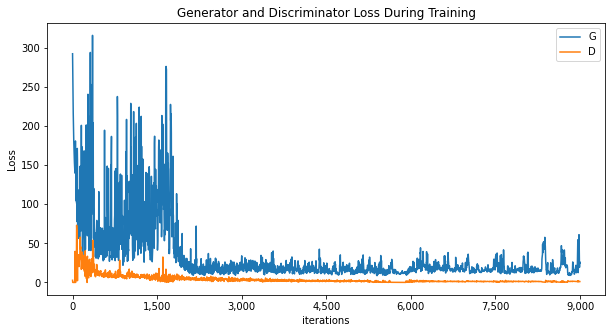

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.gca().get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x*3), ',')))
plt.show()

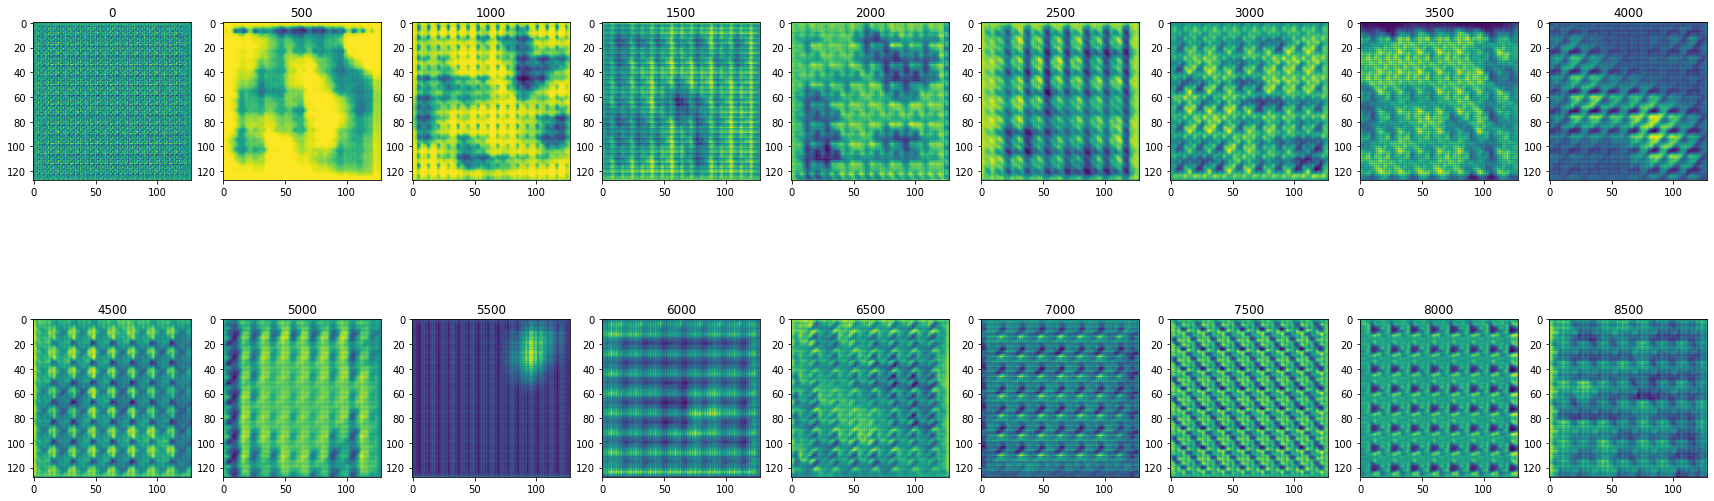

In [ ]:
plt.figure(figsize=(30,10))
for i in range(len(img_list)):
  plt.subplot(2,len(img_list)/2,i+1)
  plt.imshow(img_list[i].mean(0).mean(0))#, cmap='gray')
  plt.title('{}'.format(i*500))
plt.show()

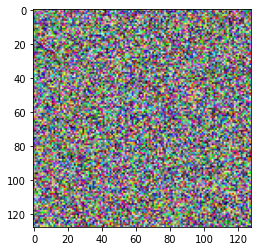

In [ ]:
plt.imshow(np.random.rand(128,128,3))

In [ ]:
torch.save(netG.state_dict(), '/content/drive/MyDrive/netG.pt')

In [ ]:
torch.save(netD.state_dict(), '/content/drive/MyDrive/netD.pt')